<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Автор материала: аналитик-разработчик в команде Яндекс.Метрики Мария Мансурова. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

#### <center>К [статье](https://habrahabr.ru/company/ods/blog/323730/) на Хабре "Предсказываем будущее с помощью библиотеки Facebook Prophet"

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd

from plotly import __version__
print(__version__) # need 1.9.0 or greater
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)
    
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

1.12.9


## Загрузка и предобработка данных
Данные [соревнования](https://inclass.kaggle.com/c/howpop-habrahabr-favs-lognorm) по прогнозу популярности статьи на Хабрахабре.

In [2]:
habr_df = pd.read_csv('../../data/howpop_train.csv')

In [3]:
habr_df['published'] = pd.to_datetime(habr_df.published)
habr_df = habr_df[['published', 'url']]
habr_df = habr_df.drop_duplicates()

In [4]:
aggr_habr_df = habr_df.groupby('published')[['url']].count()
aggr_habr_df.columns = ['posts']

In [5]:
aggr_habr_df = aggr_habr_df.resample('D').apply(sum)
plotly_df(aggr_habr_df.resample('W').apply(sum), 
          title = 'Опубликованные посты на Хабрахабре')

## Построение прогноза Prophet

In [6]:
# pip install pystan
# pip install fbprophet
from fbprophet import Prophet

In [7]:
predictions = 30

df = aggr_habr_df.reset_index()
df.columns = ['ds', 'y']
df.tail()

,ds,y
3222,2016-10-27,58.0
3223,2016-10-28,53.0
3224,2016-10-29,14.0
3225,2016-10-30,27.0
3226,2016-10-31,80.0


In [8]:
train_df = df[:-predictions]

In [9]:
m = Prophet()
m.fit(train_df)

In [10]:
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
3221,2016-10-27
3222,2016-10-28
3223,2016-10-29
3224,2016-10-30
3225,2016-10-31


In [11]:
forecast = m.predict(future)
forecast.tail()

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat
3221,2016-10-27,1.008135,56.608968,10.722472,10.722472,56.608968,56.608968,53.600279,81.818657,8.474826,8.474826,8.474826,2.247646,2.247646,2.247646,10.722472,67.331440
3222,2016-10-28,1.008448,56.604998,6.923172,6.923172,56.604998,56.604998,48.507302,77.609165,4.654179,4.654179,4.654179,2.268994,2.268994,2.268994,6.923172,63.528170
3223,2016-10-29,1.008761,56.601028,-21.054205,-21.054205,56.601028,56.601028,21.122370,49.878969,-23.328565,-23.328565,-23.328565,2.274360,2.274360,2.274360,-21.054205,35.546823
3224,2016-10-30,1.009074,56.597059,-18.631615,-18.631615,56.597003,56.597059,22.584430,50.660919,-20.895913,-20.895913,-20.895913,2.264298,2.264298,2.264298,-18.631615,37.965443
3225,2016-10-31,1.009387,56.593089,11.827474,11.827474,56.592302,56.593089,53.324032,82.618584,9.587762,9.587762,9.587762,2.239712,2.239712,2.239712,11.827474,68.420563


In [12]:
print(', '.join(forecast.columns))

ds, t, trend, seasonal_lower, seasonal_upper, trend_lower, trend_upper, yhat_lower, yhat_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, seasonal, yhat


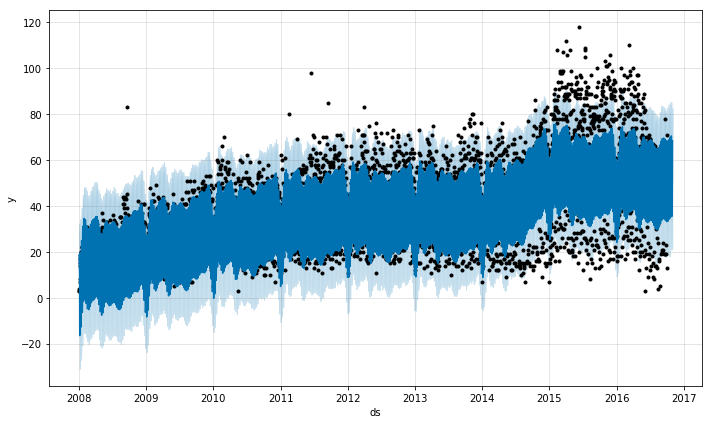

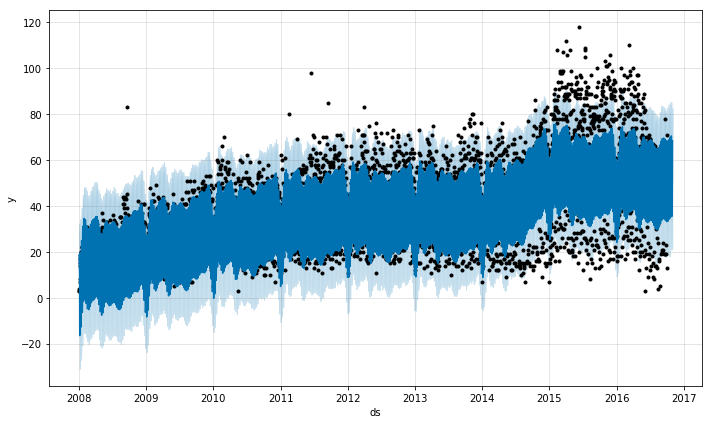

In [13]:
m.plot(forecast)

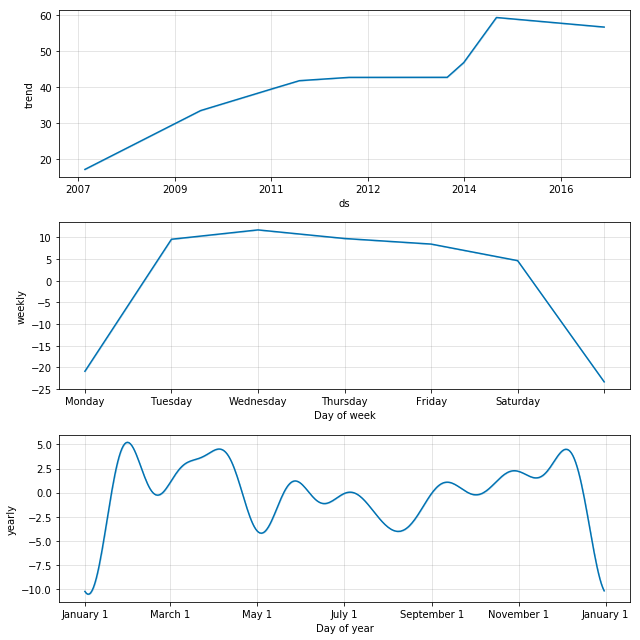

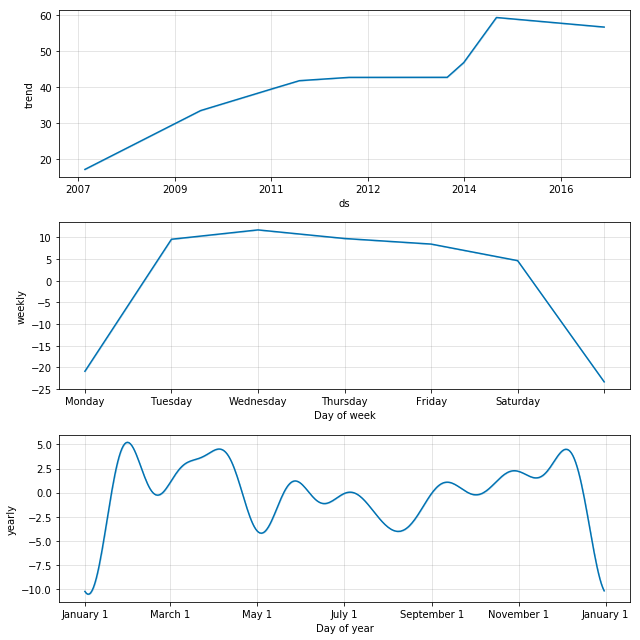

In [14]:
m.plot_components(forecast)

## Оценка качества Prophet

In [15]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [16]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
np.mean(abs(cmp_df[-predictions:]['p'])), np.mean(abs(cmp_df[-predictions:]['e']))

(37.34607096816031, 10.623727053544432)

## Прогноз с BoxCox

In [18]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

In [19]:
train_df2 = train_df.copy().fillna(14)
train_df2 = train_df2.set_index('ds')
train_df2['y'], lmbda_prophet = stats.boxcox(train_df2['y'])

train_df2.reset_index(inplace=True)

m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=30)

forecast2 = m2.predict(future2)
forecast2['yhat'] = invboxcox(forecast2.yhat, lmbda_prophet)
forecast2['yhat_lower'] = invboxcox(forecast2.yhat_lower, lmbda_prophet)
forecast2['yhat_upper'] = invboxcox(forecast2.yhat_upper, lmbda_prophet)

cmp_df2 = forecast2.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

cmp_df2['e'] = cmp_df2['y'] - cmp_df2['yhat']
cmp_df2['p'] = 100*cmp_df2['e']/cmp_df2['y']
np.mean(abs(cmp_df2[-predictions:]['p'])), np.mean(abs(cmp_df2[-predictions:]['e']))

(26.789153086481026, 8.485639747730659)

## Визуализация результатов

In [20]:
def show_forecast(cmp_df, num_predictions, num_values):
    upper_bound = go.Scatter(
        name='Upper Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_upper,
        mode='lines',
        marker=dict(color="444"),
        line=dict(width=0),
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty')

    forecast = go.Scatter(
        name='Prediction',
        x=cmp_df.tail(predictions).index,
        y=cmp_df.tail(predictions).yhat,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )

    lower_bound = go.Scatter(
        name='Lower Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_lower,
        marker=dict(color="444"),
        line=dict(width=0),
        mode='lines')

    fact = go.Scatter(
        name='Fact',
        x=cmp_df.tail(num_values).index,
        y=cmp_df.tail(num_values).y,
        marker=dict(color="red"),
        mode='lines',
    )

    # Trace order can be important
    # with continuous error bars
    data = [lower_bound, upper_bound, forecast, fact]

    layout = go.Layout(
        yaxis=dict(title='Посты'),
        title='Опубликованные посты на Хабрахабре',
        showlegend = False)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

In [21]:
show_forecast(cmp_df, predictions, 200)

##  Сравнение с ARIMA моделью

In [22]:
train_df = train_df.fillna(14).set_index('ds')

Критерий Дики-Фуллера: p=0.040528


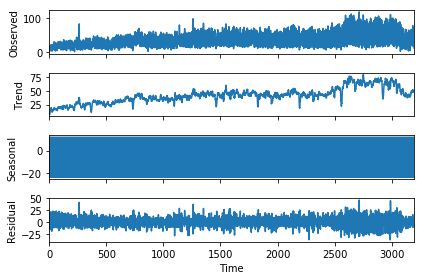

In [23]:
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(train_df['y'].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

In [24]:
train_df.index = pd.to_datetime(train_df.index)

Оптимальный параметр преобразования Бокса-Кокса: 0.415948
Критерий Дики-Фуллера: p=0.040528


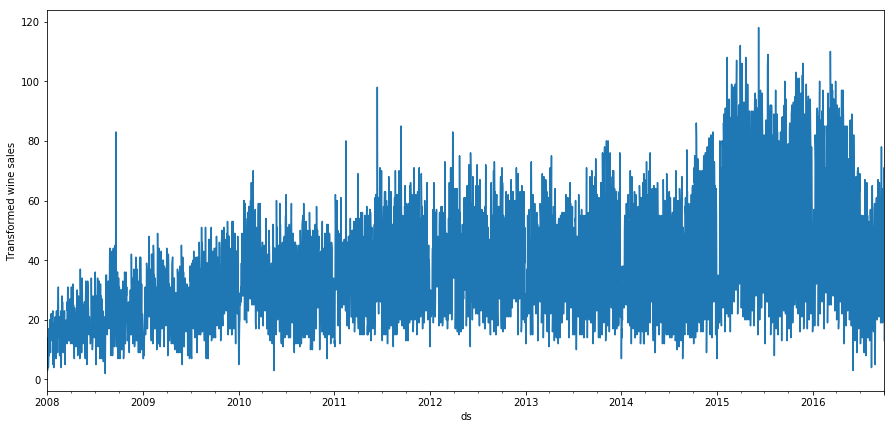

In [25]:
train_df['y_box'], lmbda = stats.boxcox([1 if x == 0 else x for x in train_df['y']])
plt.figure(figsize=(15,7))
train_df.y.plot()
plt.ylabel(u'Posts on Habr')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

Критерий Дики-Фуллера: p=0.000000


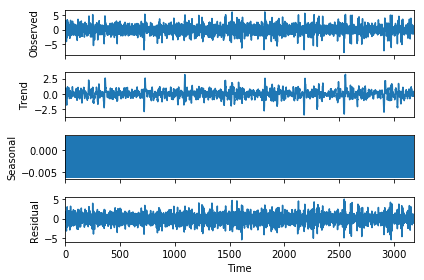

In [26]:
train_df['y_box_diff'] = train_df.y_box - train_df.y_box.shift(7)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(train_df.y_box_diff[12:].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df.y_box_diff[8:])[1])

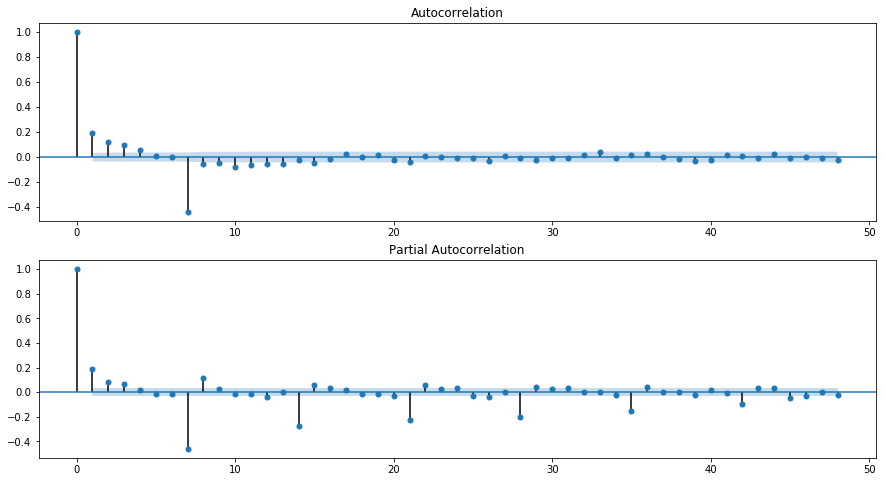

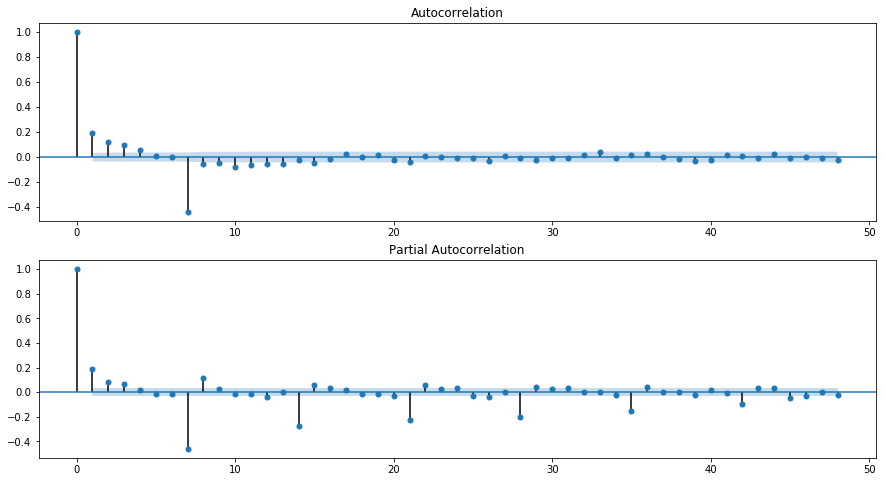

In [27]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.y_box_diff[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.y_box_diff[13:].values.squeeze(), lags=48, ax=ax)

Начальные приближения Q = 1, q = 4, P = 5, p = 3

In [28]:
ps = range(0, 4)
d=1
qs = range(0, 5)
Ps = range(0, 7)
D=1
Qs = range(0, 2)

In [29]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

280

In [30]:
%%time
results = []
best_aic = float("inf")



for param in parameters_list:
    print(param)
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        %time model=sm.tsa.statespace.SARIMAX(train_df.y_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

(0, 0, 0, 0)
wrong parameters: (0, 0, 0, 0)
(0, 0, 0, 1)
CPU times: user 1.62 s, sys: 55.2 ms, total: 1.68 s
Wall time: 1.1 s
(0, 0, 1, 0)
CPU times: user 1.41 s, sys: 36.2 ms, total: 1.44 s
Wall time: 858 ms
(0, 0, 1, 1)
CPU times: user 1.72 s, sys: 53.2 ms, total: 1.77 s
Wall time: 1.16 s
(0, 0, 2, 0)
CPU times: user 1.82 s, sys: 97.2 ms, total: 1.92 s
Wall time: 1.13 s
(0, 0, 2, 1)
CPU times: user 2.81 s, sys: 93.6 ms, total: 2.91 s
Wall time: 1.81 s
(0, 0, 3, 0)
CPU times: user 2.81 s, sys: 254 ms, total: 3.07 s
Wall time: 1.86 s
(0, 0, 3, 1)
CPU times: user 4.66 s, sys: 167 ms, total: 4.83 s
Wall time: 3.22 s
(0, 0, 4, 0)
CPU times: user 10.3 s, sys: 423 ms, total: 10.7 s
Wall time: 2.72 s
(0, 0, 4, 1)
CPU times: user 24.1 s, sys: 449 ms, total: 24.5 s
Wall time: 6.16 s
(0, 0, 5, 0)
CPU times: user 13.8 s, sys: 475 ms, total: 14.2 s
Wall time: 3.59 s
(0, 0, 5, 1)
CPU times: user 36.1 s, sys: 952 ms, total: 37.1 s
Wall time: 9.45 s
(0, 0, 6, 0)
CPU times: user 17.5 s, sys: 732 ms, 

/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 5.54 s, sys: 196 ms, total: 5.74 s
Wall time: 4.82 s
(0, 3, 0, 1)
CPU times: user 2.9 s, sys: 131 ms, total: 3.03 s
Wall time: 2.3 s
(0, 3, 1, 0)
CPU times: user 5.49 s, sys: 63.4 ms, total: 5.55 s
Wall time: 4.96 s
(0, 3, 1, 1)
CPU times: user 4.92 s, sys: 113 ms, total: 5.04 s
Wall time: 4.44 s
(0, 3, 2, 0)
CPU times: user 11.2 s, sys: 124 ms, total: 11.3 s
Wall time: 9.53 s
(0, 3, 2, 1)
CPU times: user 6.46 s, sys: 131 ms, total: 6.59 s
Wall time: 5.17 s
(0, 3, 3, 0)
CPU times: user 22.9 s, sys: 265 ms, total: 23.1 s
Wall time: 20.4 s
(0, 3, 3, 1)
CPU times: user 13.5 s, sys: 255 ms, total: 13.7 s
Wall time: 11.6 s
(0, 3, 4, 0)
CPU times: user 25.1 s, sys: 490 ms, total: 25.6 s
Wall time: 6.44 s
(0, 3, 4, 1)
CPU times: user 1min 45s, sys: 1.35 s, total: 1min 47s
Wall time: 27.2 s
(0, 3, 5, 0)
CPU times: user 24.1 s, sys: 719 ms, total: 24.8 s
Wall time: 6.31 s
(0, 3, 5, 1)
CPU times: user 1min 39s, sys: 4.94 s, total: 1min 44s
Wall time: 28.1 s
(0, 3, 6, 0)
CPU times

/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 5.85 s, sys: 230 ms, total: 6.08 s
Wall time: 5.19 s
(0, 4, 0, 1)
CPU times: user 5.1 s, sys: 139 ms, total: 5.24 s
Wall time: 4.5 s
(0, 4, 1, 0)
CPU times: user 5.65 s, sys: 66.6 ms, total: 5.72 s
Wall time: 5.12 s
(0, 4, 1, 1)
CPU times: user 4.11 s, sys: 103 ms, total: 4.21 s
Wall time: 3.58 s
(0, 4, 2, 0)
CPU times: user 11.2 s, sys: 130 ms, total: 11.3 s
Wall time: 9.08 s
(0, 4, 2, 1)
CPU times: user 7.96 s, sys: 169 ms, total: 8.13 s
Wall time: 6.66 s
(0, 4, 3, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 21.8 s, sys: 251 ms, total: 22 s
Wall time: 19.3 s
(0, 4, 3, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 16.4 s, sys: 179 ms, total: 16.6 s
Wall time: 14.6 s
(0, 4, 4, 0)
CPU times: user 2min 40s, sys: 1.1 s, total: 2min 41s
Wall time: 40.9 s
(0, 4, 4, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 9s, sys: 1.65 s, total: 2min 10s
Wall time: 33.4 s
(0, 4, 5, 0)
CPU times: user 4min 12s, sys: 2.41 s, total: 4min 14s
Wall time: 1min 4s
(0, 4, 5, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 3min 56s, sys: 3.25 s, total: 3min 59s
Wall time: 1min 1s
(0, 4, 6, 0)
CPU times: user 5min 42s, sys: 3.09 s, total: 5min 45s
Wall time: 1min 27s
(0, 4, 6, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 3min 20s, sys: 2 s, total: 3min 22s
Wall time: 51.2 s
(1, 0, 0, 0)
CPU times: user 1.59 s, sys: 143 ms, total: 1.74 s
Wall time: 790 ms
(1, 0, 0, 1)
CPU times: user 1.81 s, sys: 99.8 ms, total: 1.91 s
Wall time: 1.18 s
(1, 0, 1, 0)
CPU times: user 1.52 s, sys: 52.8 ms, total: 1.57 s
Wall time: 950 ms
(1, 0, 1, 1)
CPU times: user 1.82 s, sys: 33.2 ms, total: 1.85 s
Wall time: 1.23 s
(1, 0, 2, 0)
CPU times: user 2.07 s, sys: 95 ms, total: 2.17 s
Wall time: 1.3 s
(1, 0, 2, 1)
CPU times: user 3.19 s, sys: 108 ms, total: 3.3 s
Wall time: 2.09 s
(1, 0, 3, 0)
CPU times: user 2.83 s, sys: 136 ms, total: 2.97 s
Wall time: 1.87 s
(1, 0, 3, 1)
CPU times: user 5.29 s, sys: 154 ms, total: 5.45 s
Wall time: 3.77 s
(1, 0, 4, 0)
CPU times: user 11.5 s, sys: 293 ms, total: 11.8 s
Wall time: 2.95 s
(1, 0, 4, 1)
CPU times: user 30.4 s, sys: 1.17 s, total: 31.6 s
Wall time: 8.37 s
(1, 0, 5, 0)
CPU times: user 15.2 s, sys: 500 ms, total: 15.7 s
Wall time: 3.99 s
(1, 0, 5, 1)
CPU times: user

/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 6.61 s, sys: 206 ms, total: 6.81 s
Wall time: 5.87 s
(1, 4, 0, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 6.69 s, sys: 178 ms, total: 6.87 s
Wall time: 6.19 s
(1, 4, 1, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 7.28 s, sys: 109 ms, total: 7.39 s
Wall time: 6.81 s
(1, 4, 1, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 7.44 s, sys: 136 ms, total: 7.58 s
Wall time: 7.01 s
(1, 4, 2, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 16.2 s, sys: 176 ms, total: 16.4 s
Wall time: 14.2 s
(1, 4, 2, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 13.1 s, sys: 202 ms, total: 13.3 s
Wall time: 11.4 s
(1, 4, 3, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 26.4 s, sys: 388 ms, total: 26.8 s
Wall time: 23.7 s
(1, 4, 3, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 21 s, sys: 301 ms, total: 21.3 s
Wall time: 19.1 s
(1, 4, 4, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 3min 41s, sys: 1.97 s, total: 3min 43s
Wall time: 56.6 s
(1, 4, 4, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 25s, sys: 1.74 s, total: 2min 27s
Wall time: 37.5 s
(1, 4, 5, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 4min 56s, sys: 2.75 s, total: 4min 59s
Wall time: 1min 16s
(1, 4, 5, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 3min 40s, sys: 4.1 s, total: 3min 44s
Wall time: 57.8 s
(1, 4, 6, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 4min 12s, sys: 3.43 s, total: 4min 15s
Wall time: 1min 4s
(1, 4, 6, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 3min 45s, sys: 4.79 s, total: 3min 50s
Wall time: 59.3 s
(2, 0, 0, 0)
CPU times: user 1.79 s, sys: 227 ms, total: 2.02 s
Wall time: 995 ms
(2, 0, 0, 1)
CPU times: user 2.09 s, sys: 190 ms, total: 2.28 s
Wall time: 1.6 s
(2, 0, 1, 0)
CPU times: user 1.65 s, sys: 101 ms, total: 1.75 s
Wall time: 1.18 s
(2, 0, 1, 1)
CPU times: user 2.18 s, sys: 110 ms, total: 2.29 s
Wall time: 1.71 s
(2, 0, 2, 0)
CPU times: user 2.23 s, sys: 142 ms, total: 2.37 s
Wall time: 1.5 s
(2, 0, 2, 1)
CPU times: user 3.75 s, sys: 196 ms, total: 3.95 s
Wall time: 2.58 s
(2, 0, 3, 0)
CPU times: user 3.33 s, sys: 210 ms, total: 3.54 s
Wall time: 2.36 s
(2, 0, 3, 1)
CPU times: user 6.15 s, sys: 256 ms, total: 6.41 s
Wall time: 4.64 s
(2, 0, 4, 0)
CPU times: user 12.5 s, sys: 385 ms, total: 12.9 s
Wall time: 3.26 s
(2, 0, 4, 1)
CPU times: user 30.8 s, sys: 933 ms, total: 31.7 s
Wall time: 8.15 s
(2, 0, 5, 0)
CPU times: user 18.4 s, sys: 1.22 s, total: 19.7 s
Wall time: 5.32 s
(2, 0, 5, 1)
CPU times: use

/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 4.49 s, sys: 268 ms, total: 4.75 s
Wall time: 3.93 s
(2, 3, 0, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 6.82 s, sys: 236 ms, total: 7.06 s
Wall time: 6.48 s
(2, 3, 1, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 7.38 s, sys: 125 ms, total: 7.51 s
Wall time: 6.93 s
(2, 3, 1, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 7.48 s, sys: 129 ms, total: 7.61 s
Wall time: 7.05 s
(2, 3, 2, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 11.8 s, sys: 240 ms, total: 12 s
Wall time: 9.43 s
(2, 3, 2, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 10.6 s, sys: 150 ms, total: 10.8 s
Wall time: 9.05 s
(2, 3, 3, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 17 s, sys: 314 ms, total: 17.3 s
Wall time: 13.6 s
(2, 3, 3, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 19.5 s, sys: 324 ms, total: 19.8 s
Wall time: 16.9 s
(2, 3, 4, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 35s, sys: 3.85 s, total: 1min 39s
Wall time: 26.2 s
(2, 3, 4, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 58s, sys: 3.15 s, total: 2min 1s
Wall time: 31.5 s
(2, 3, 5, 0)
CPU times: user 58.5 s, sys: 2.1 s, total: 1min
Wall time: 15.8 s
(2, 3, 5, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 57s, sys: 4.5 s, total: 3min 1s
Wall time: 47.1 s
(2, 3, 6, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 55s, sys: 2.49 s, total: 1min 57s
Wall time: 30.3 s
(2, 3, 6, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 3min 8s, sys: 6.21 s, total: 3min 14s
Wall time: 51.1 s
(2, 4, 0, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 6.69 s, sys: 157 ms, total: 6.84 s
Wall time: 5.98 s
(2, 4, 0, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 7.28 s, sys: 125 ms, total: 7.41 s
Wall time: 6.73 s
(2, 4, 1, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 9.71 s, sys: 52.6 ms, total: 9.76 s
Wall time: 9.17 s
(2, 4, 1, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 8.29 s, sys: 93 ms, total: 8.39 s
Wall time: 7.75 s
(2, 4, 2, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 16.2 s, sys: 196 ms, total: 16.4 s
Wall time: 13.8 s
(2, 4, 2, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 12.9 s, sys: 221 ms, total: 13.1 s
Wall time: 11 s
(2, 4, 3, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 31.8 s, sys: 426 ms, total: 32.2 s
Wall time: 28.7 s
(2, 4, 3, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 22.2 s, sys: 394 ms, total: 22.6 s
Wall time: 19.9 s
(2, 4, 4, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 27s, sys: 2.62 s, total: 1min 30s
Wall time: 23.4 s
(2, 4, 4, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 12s, sys: 3.18 s, total: 2min 16s
Wall time: 35.1 s
(2, 4, 5, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 28s, sys: 1.35 s, total: 1min 30s
Wall time: 22.7 s
(2, 4, 5, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 49s, sys: 2.96 s, total: 2min 52s
Wall time: 44.2 s
(2, 4, 6, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 53s, sys: 4.7 s, total: 2min 58s
Wall time: 46.1 s
(2, 4, 6, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 3min 31s, sys: 2.93 s, total: 3min 34s
Wall time: 54.4 s
(3, 0, 0, 0)
CPU times: user 1.65 s, sys: 152 ms, total: 1.81 s
Wall time: 945 ms
(3, 0, 0, 1)
CPU times: user 1.97 s, sys: 99.2 ms, total: 2.07 s
Wall time: 1.41 s
(3, 0, 1, 0)
CPU times: user 1.78 s, sys: 70.7 ms, total: 1.85 s
Wall time: 1.23 s
(3, 0, 1, 1)
CPU times: user 2.2 s, sys: 65 ms, total: 2.26 s
Wall time: 1.62 s
(3, 0, 2, 0)
CPU times: user 2.65 s, sys: 126 ms, total: 2.78 s
Wall time: 1.76 s
(3, 0, 2, 1)
CPU times: user 4.3 s, sys: 130 ms, total: 4.43 s
Wall time: 2.92 s
(3, 0, 3, 0)
CPU times: user 9.23 s, sys: 235 ms, total: 9.46 s
Wall time: 2.38 s
(3, 0, 3, 1)
CPU times: user 19 s, sys: 372 ms, total: 19.4 s
Wall time: 4.89 s
(3, 0, 4, 0)
CPU times: user 14 s, sys: 374 ms, total: 14.4 s
Wall time: 3.62 s
(3, 0, 4, 1)
CPU times: user 34.6 s, sys: 1.23 s, total: 35.8 s
Wall time: 9.3 s
(3, 0, 5, 0)
CPU times: user 19.4 s, sys: 1.6 s, total: 21 s
Wall time: 5.8 s
(3, 0, 5, 1)
CPU times: user 53.6 s

/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 4.18 s, sys: 179 ms, total: 4.36 s
Wall time: 3.5 s
(3, 3, 0, 1)
CPU times: user 5.77 s, sys: 142 ms, total: 5.91 s
Wall time: 5.29 s
(3, 3, 1, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 5.51 s, sys: 79.7 ms, total: 5.59 s
Wall time: 4.96 s
(3, 3, 1, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 7.86 s, sys: 65.8 ms, total: 7.92 s
Wall time: 7.29 s
(3, 3, 2, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 18.6 s, sys: 182 ms, total: 18.8 s
Wall time: 15.7 s
(3, 3, 2, 1)
CPU times: user 11.1 s, sys: 186 ms, total: 11.3 s
Wall time: 9.2 s
(3, 3, 3, 0)
CPU times: user 1min 50s, sys: 512 ms, total: 1min 50s
Wall time: 27.7 s
(3, 3, 3, 1)
CPU times: user 1min 9s, sys: 982 ms, total: 1min 10s
Wall time: 17.7 s
(3, 3, 4, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 3min 14s, sys: 676 ms, total: 3min 14s
Wall time: 48.8 s
(3, 3, 4, 1)
CPU times: user 1min 25s, sys: 1.28 s, total: 1min 26s
Wall time: 22 s
(3, 3, 5, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 17s, sys: 1.76 s, total: 1min 19s
Wall time: 20.2 s
(3, 3, 5, 1)
CPU times: user 2min 30s, sys: 1.27 s, total: 2min 31s
Wall time: 38.1 s
(3, 3, 6, 0)
CPU times: user 1min 19s, sys: 1.11 s, total: 1min 21s
Wall time: 20.5 s
(3, 3, 6, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 3min 33s, sys: 2.05 s, total: 3min 35s
Wall time: 54.3 s
(3, 4, 0, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 7 s, sys: 153 ms, total: 7.15 s
Wall time: 6.27 s
(3, 4, 0, 1)
CPU times: user 7.69 s, sys: 116 ms, total: 7.81 s
Wall time: 7.12 s
(3, 4, 1, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 9.92 s, sys: 54.8 ms, total: 9.97 s
Wall time: 9.38 s
(3, 4, 1, 1)
CPU times: user 7.66 s, sys: 80.9 ms, total: 7.74 s
Wall time: 7.1 s
(3, 4, 2, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 20.9 s, sys: 159 ms, total: 21 s
Wall time: 17.9 s
(3, 4, 2, 1)
CPU times: user 16.2 s, sys: 164 ms, total: 16.4 s
Wall time: 14.4 s
(3, 4, 3, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 24s, sys: 1.46 s, total: 2min 26s
Wall time: 37.1 s
(3, 4, 3, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 19s, sys: 3.39 s, total: 2min 22s
Wall time: 37.4 s
(3, 4, 4, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 4min 2s, sys: 7.42 s, total: 4min 9s
Wall time: 1min 7s
(3, 4, 4, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 34s, sys: 4.29 s, total: 2min 38s
Wall time: 41.7 s
(3, 4, 5, 0)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 5min 2s, sys: 2.84 s, total: 5min 5s
Wall time: 1min 17s
(3, 4, 5, 1)


/Users/y.kashnitsky/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:475: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 3min 6s, sys: 3.45 s, total: 3min 10s
Wall time: 48.6 s
(3, 4, 6, 0)
CPU times: user 7min 57s, sys: 6.81 s, total: 8min 4s
Wall time: 2min 3s
(3, 4, 6, 1)
CPU times: user 4min 50s, sys: 6.8 s, total: 4min 57s
Wall time: 1min 16s
CPU times: user 3h 15min 1s, sys: 4min 11s, total: 3h 19min 12s
Wall time: 59min 21s


In [31]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters          aic
212  (3, 4, 1, 1)  9597.534822
214  (3, 4, 2, 1)  9598.589146
216  (3, 4, 3, 1)  9599.138188
220  (3, 4, 5, 1)  9600.614474
218  (3, 4, 4, 1)  9601.080671


In [32]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             y_box   No. Observations:                 3197
Model:             SARIMAX(3, 1, 4)x(1, 1, 1, 7)   Log Likelihood               -4788.767
Date:                           Thu, 23 Mar 2017   AIC                           9597.535
Time:                                   12:59:12   BIC                           9658.235
Sample:                               01-01-2008   HQIC                          9619.298
                                    - 10-01-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2363      0.217     -1.088      0.276      -0.662       0.189
ar.L2          0.1763      0.145      1.219

Критерий Стьюдента: p=0.050812
Критерий Дики-Фуллера: p=0.000000


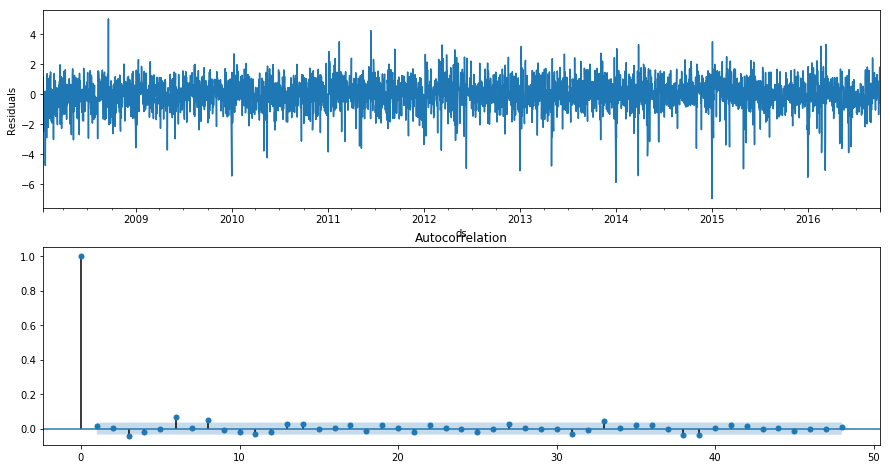

In [34]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

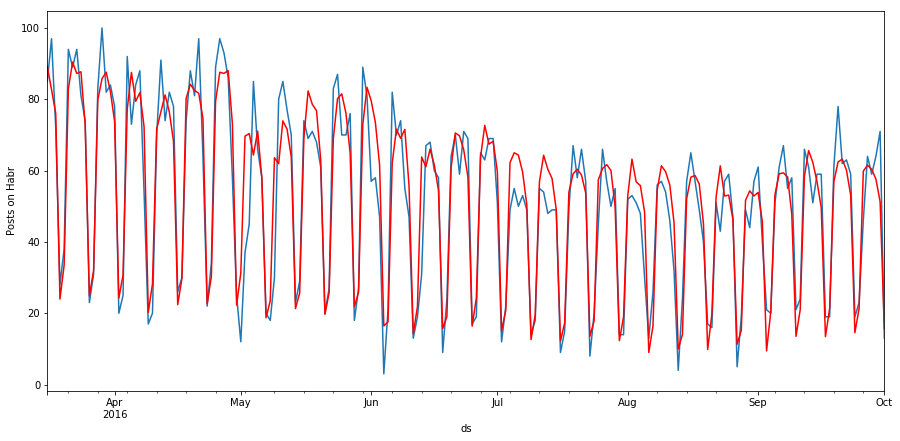

In [37]:
train_df['arima_model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
train_df.y.tail(200).plot()
train_df.arima_model[13:].tail(200).plot(color='r')
plt.ylabel('Posts on Habr');

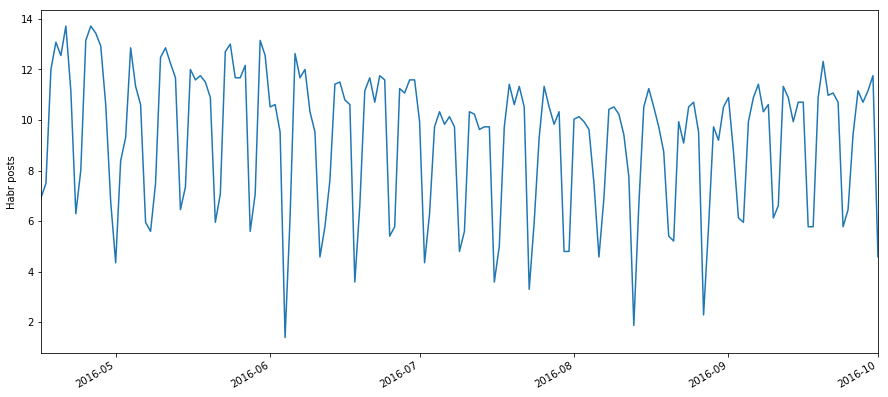

In [55]:
arima_df = train_df2.set_index('ds')[['y']]

date_list = [pd.datetime.strptime("2016-10-01", "%Y-%m-%d") + 
             pd.Timedelta(x) for x in range(0, predictions+1)]
future = pd.DataFrame(index=date_list, columns= arima_df.columns)
arima_df = pd.concat([arima_df, future])
arima_df['forecast'] = invboxcox(best_model.predict(start=train_df.shape[0], end=train_df.shape[0]+predictions-1), lmbda)
plt.figure(figsize=(15,7))
arima_df.y.tail(200).plot()
arima_df.forecast.tail(200).plot(color='r')
plt.ylabel('Habr posts');

In [59]:
cmp_df.head()

,yhat,yhat_lower,yhat_upper,y,e,p,forecast,e_arima,p_arima
2008-01-01,18.623500,3.257950,32.626385,3.0,-15.623500,-520.783317,NaN,NaN,NaN
2008-01-02,16.464544,1.836996,31.509440,3.0,-13.464544,-448.818118,NaN,NaN,NaN
2008-01-03,15.108129,-0.062345,30.097931,4.0,-11.108129,-277.703219,NaN,NaN,NaN
2008-01-04,11.324859,-3.324523,26.584102,14.0,2.675141,19.108148,NaN,NaN,NaN
2008-01-05,-16.512771,-30.686008,-1.566509,4.0,20.512771,512.819264,NaN,NaN,NaN


In [62]:
cmp_df = cmp_df.join(arima_df[['forecast']])

In [63]:
import numpy as np
cmp_df['e_arima'] = cmp_df['y'] - cmp_df['forecast']
cmp_df['p_arima'] = 100*cmp_df['e_arima']/cmp_df['y']

In [64]:
num_values = 200

forecast = go.Scatter(
    name='Prophet',
    x=cmp_df.tail(predictions).index,
    y=cmp_df.tail(predictions).yhat,
    mode='lines',
    line=dict(color='rgb(31, 119, 180)'),
)


fact = go.Scatter(
    name='Fact',
    x=cmp_df.tail(num_values).index,
    y=cmp_df.tail(num_values).y,
    marker=dict(color="red"),
    mode='lines',
)

arima = go.Scatter(
    name='ARIMA',
    x=cmp_df.tail(predictions).index,
    y=cmp_df.tail(predictions).forecast,
    mode='lines'
)

# Trace order can be important
# with continuous error bars
data = [forecast, fact, arima]

layout = go.Layout(
    yaxis=dict(title='Посты'),
    title='Опубликованные посты на Хабрахабре',
    showlegend = True)

fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)